In [1]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import json
import os
import re
import contractions
import string
import seaborn as sns
from tabulate import tabulate
from urllib.parse import urljoin  
import pickle as pkl
import community as community_louvain
from collections import Counter
from fa2_modified import ForceAtlas2
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from PIL import Image
from rapidfuzz import process

In [2]:
df = pd.read_csv('df_text_c1.csv')

In [3]:
df

,text_no_emoji,lang,translated_text
0,jai pas les mots,lv,I don't have the words
1,juste admire,et,just admire
2,jai besoin dun bavoir,fi,I need a bib
3,yes chef,en,yes chef
4,fell knees,no,fell knees
...,...,...,...
6678,guess hour long dissection video,en,guess hour long dissection video
6679,rosalia knows things,en,rosalia knows things
6680,grazie,pl,Thank you
6681,hermanas,en,hermanas


In [4]:
def clean_text_extra(translated_text):
    # Make all text strings
    translated_text = str(translated_text)
    
    # Expand contractions (e.g., "I'm" -> "I am")
    text_expanded = contractions.fix(translated_text)
    
    # Lowercase the text
    text_expanded = text_expanded.lower()
    
    # Remove punctuation
    text_nopoints = text_expanded.translate(str.maketrans('', '', string.punctuation))
    
    # Normalize spaces (remove extra whitespace)
    text_nospace = ' '.join(text_nopoints.split())
    
    # Remove stopwords
    stopwords_en = set(stopwords.words('english'))
    words_no_stopword = [word for word in text_nospace.split() if word not in stopwords_en]
    
    # Remove tokens that are not purely alphabetical
    words_no_number = [word for word in words_no_stopword if word.isalpha()]
    
    cleaned_text = ' '.join(words_no_number)
    return cleaned_text
     

In [5]:
# Apply the updated clean_text function to create a new column
df['processed_text'] = df['translated_text'].apply(clean_text_extra)

# Display first few rows to verify
print(df[['processed_text']].head())

  processed_text
0          words
1         admire
2       need bib
3       yes chef
4     fell knees


In [6]:
# Tokenize the 'processed_text' column and store in a new DataFrame
df_tokens = df['processed_text'].apply(lambda x: x.split())
df_tokenized = pd.DataFrame({'tokens': df_tokens})

# Display the first few rows
print(df_tokenized.head())

          tokens
0        [words]
1       [admire]
2    [need, bib]
3    [yes, chef]
4  [fell, knees]


In [7]:
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

df["sentiment_score"] = df["processed_text"].apply(lambda x: sid.polarity_scores(x)["compound"])

df["sentiment_label"] = df["sentiment_score"].apply(
    lambda x: "positive" if x > 0.05 else ("negative" if x < -0.05 else "neutral")
)

# Quick stats
print(df["sentiment_label"].value_counts())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nba\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment_label
neutral     3425
positive    2674
negative     584
Name: count, dtype: int64


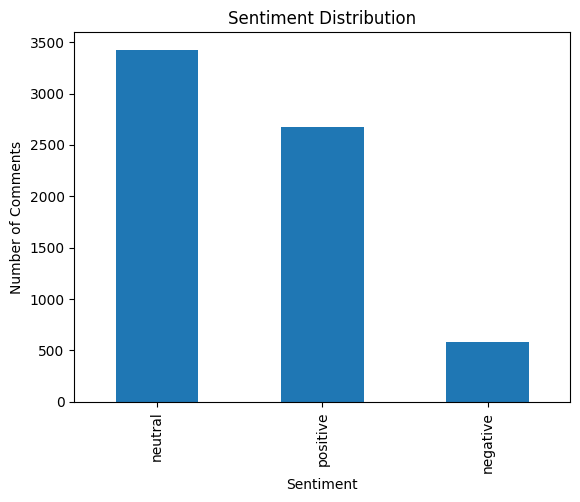

In [8]:
df["sentiment_label"].value_counts().plot(kind="bar", title="Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.show()

In [9]:
from nltk.util import ngrams
from collections import Counter

# Flatten all tokens into a single list
all_tokens = [token for tokens in df_tokenized['tokens'] for token in tokens]

# Generate bigrams and trigrams from each row, then flatten
bigrams = [bigram for tokens in df_tokenized['tokens'] for bigram in ngrams(tokens, 2)]
trigrams = [trigram for tokens in df_tokenized['tokens'] for trigram in ngrams(tokens, 3)]

# Count frequencies
bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

# Display most common bigrams and trigrams
print("Most common bigrams:")
for phrase, count in bigram_counts.most_common(10):
    print(f"{phrase}: {count}")

print("\nMost common trigrams:")
for phrase, count in trigram_counts.most_common(10):
    print(f"{phrase}: {count}")

Most common bigrams:
('yes', 'chef'): 338
('calvin', 'klein'): 122
('many', 'times'): 68
('understand', 'rosalia'): 50
('times', 'watched'): 33
('thank', 'calvin'): 32
('god', 'bless'): 29
('cannot', 'stop'): 27
('lip', 'gallagher'): 24
('hours', 'long'): 24

Most common trigrams:
('many', 'times', 'watched'): 28
('thank', 'calvin', 'klein'): 22
('times', 'watched', 'yes'): 17
('thanks', 'calvin', 'klein'): 16
('video', 'hours', 'long'): 16
('cannot', 'stop', 'watching'): 14
('ask', 'color', 'anything'): 11
('jeremy', 'allen', 'white'): 10
('good', 'morning', 'men'): 10
('morning', 'men', 'live'): 10


C:\Users\nba\AppData\Local\Temp\ipykernel_47236\3055144674.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_values, y=bigram_labels, ax=axes[0], palette="Blues_d")
C:\Users\nba\AppData\Local\Temp\ipykernel_47236\3055144674.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trigram_values, y=trigram_labels, ax=axes[1], palette="Greens_d")


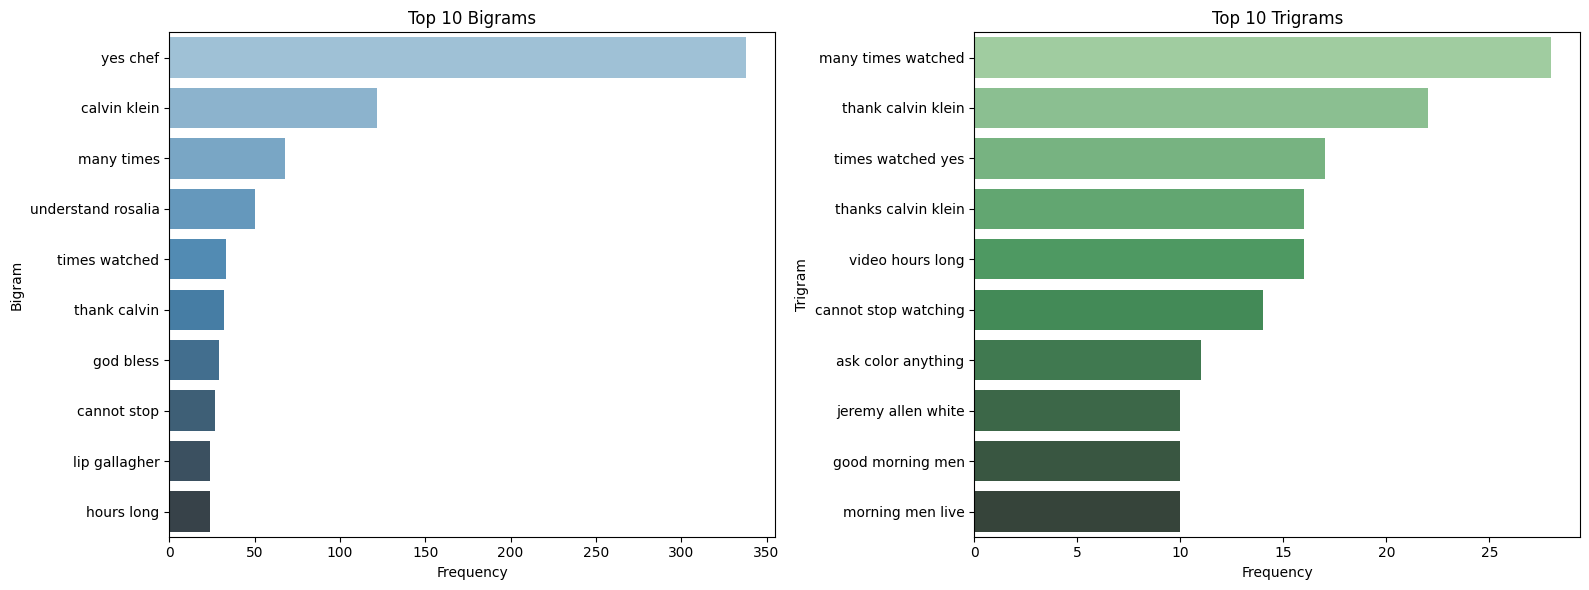

In [10]:
# Prepare data for plotting
top_n = 10
top_bigrams = bigram_counts.most_common(top_n)
top_trigrams = trigram_counts.most_common(top_n)

# Convert tuples to strings for plotting
bigram_labels = [' '.join(bigram) for bigram, _ in top_bigrams]
bigram_values = [count for _, count in top_bigrams]

trigram_labels = [' '.join(trigram) for trigram, _ in top_trigrams]
trigram_values = [count for _, count in top_trigrams]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot bigrams
sns.barplot(x=bigram_values, y=bigram_labels, ax=axes[0], palette="Blues_d")
axes[0].set_title('Top 10 Bigrams')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Bigram')

# Plot trigrams
sns.barplot(x=trigram_values, y=trigram_labels, ax=axes[1], palette="Greens_d")
axes[1].set_title('Top 10 Trigrams')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Trigram')

plt.tight_layout()
plt.show()


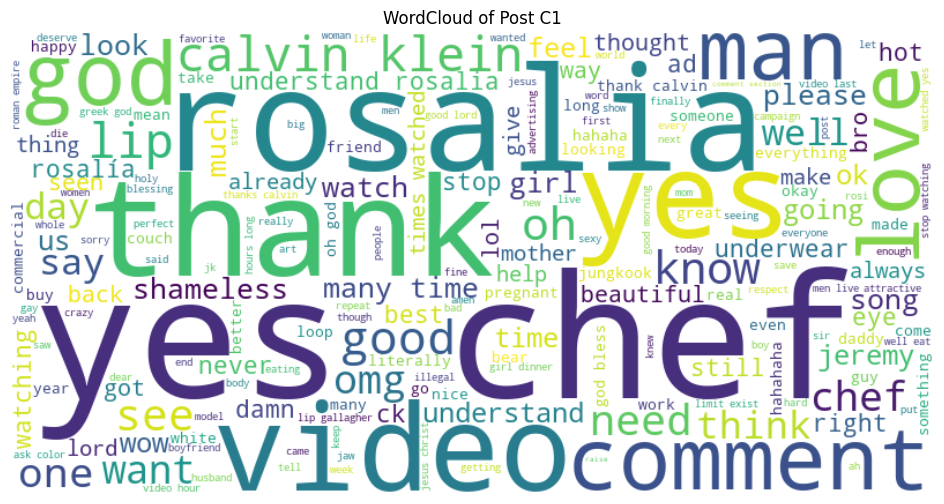

In [11]:
# Unify all tokens from df_tokenized into a single string
all_words = ' '.join([word for tokens in df_tokenized['tokens'] for word in tokens])

# Generate and display the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Post C1')
plt.show()

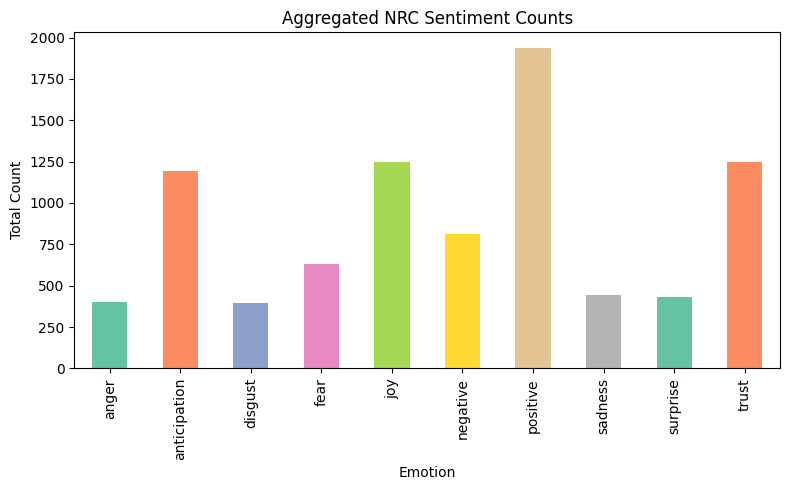

In [12]:
def get_nrc_sentiments(tokens):
    text = ' '.join(tokens)               # join tokens back into a string
    lex = NRCLex(text)                    # feed to NRC
    return lex.raw_emotion_scores        # dict of {emotion: count}

df_tokenized['sentiment_counts'] = df_tokenized['tokens'].apply(get_nrc_sentiments)

sentiment_df = df_tokenized['sentiment_counts'] \
               .apply(pd.Series) \
               .fillna(0) \
               .astype(int)

df_result = pd.concat([df_tokenized, sentiment_df], axis=1)

# 5) Aggregate across all rows and plot
agg_counts = sentiment_df.sum()

plt.figure(figsize=(8,5))
agg_counts = agg_counts.sort_index()

# Use a different color palette (e.g., 'Set2')
agg_counts.plot(kind='bar', color=sns.color_palette('Set2', n_colors=len(agg_counts)))

plt.title('Aggregated NRC Sentiment Counts')
plt.xlabel('Emotion')
plt.ylabel('Total Count')
plt.tight_layout()
plt.show()

In [13]:
sentiment_df 

,anger,negative,positive,trust,sadness,anticipation,joy,disgust,fear,surprise
0,1,1,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6678,0,0,0,0,0,1,0,1,0,1
6679,0,0,0,0,0,0,0,0,0,0
6680,0,0,0,0,0,0,0,0,0,0
6681,0,0,0,0,0,0,0,0,0,0


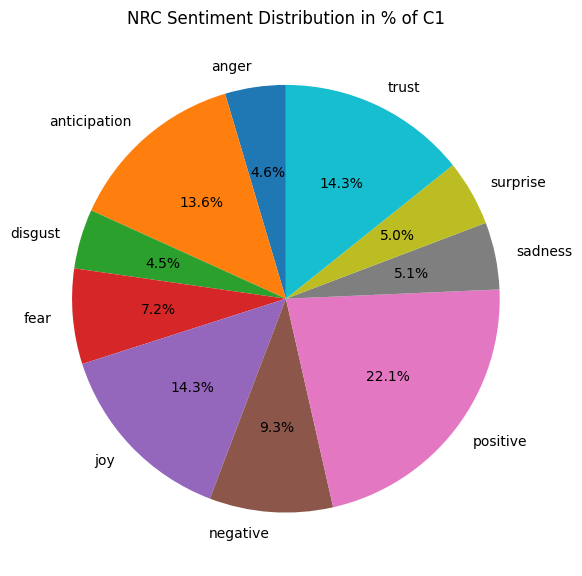

In [14]:
plt.figure(figsize=(6,6))
agg_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    ylabel=''
)
plt.title('NRC Sentiment Distribution in % of C1')
plt.tight_layout()
plt.show()